In [1]:
import pandas as pd
import tarfile
from bs4 import BeautifulSoup
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import numpy as np

import warnings
warnings.filterwarnings("ignore", message= 'Inverting hessian failed')
warnings.filterwarnings("ignore", message= 'Maximum Likelihood optimization failed to converge')
warnings.filterwarnings("ignore", message= 'invalid value encountered')
warnings.filterwarnings("ignore", message= 'overflow encountered')
warnings.filterwarnings("ignore", message= 'divide by zero encountered')

rep_dem_diffs = pd.DataFrame()
rep_ind_diffs = pd.DataFrame()
dem_ind_diffs = pd.DataFrame()

%run -i "functions/unzip.py"
%run -i "functions/scrape_platforms.py"
%run -i "functions/scrape_SotU.py"
%run -i "functions/create_ts.py"
%run -i "functions/party_splits.py"
%run -i "functions/make_preds.py"
%run -i "functions/store_predictions.py"
%run -i "functions/save.py"

# Survey Data
#### Weights
This function will encorporate sample weights provided by the University of Chicago General Social Survey, which is the source of all the survey data used in this analysis.

In [2]:
weights = unzip('Weights')
def weight(df):
    return df.loc[df.index.repeat(round(weights['Weight variable']*10, 0))].reset_index()

<hr style="border:3px solid gray"> </hr>

## Party Affiliation

<hr style="border:3px solid gray"> </hr> 

#### Cleaning

In [3]:
party = unzip('Voter_Identity')
party = party[['year', 'Political party affiliation']]
party = weight(party)
party.drop('index', axis = 1, inplace= True)
party.head()

,year,Political party affiliation
0,1972,"Ind,near dem"
1,1972,"Ind,near dem"
2,1972,"Ind,near dem"
3,1972,"Ind,near dem"
4,1972,Not str democrat


In [4]:
party.rename(columns = {'Political party affiliation':'party'}, inplace=True)
party['party'].value_counts()

Not str democrat      131833
Not str republican    101264
Independent           100052
Strong democrat        99652
Ind,near dem           76687
Strong republican      63506
Ind,near rep           58747
Other party            10708
No answer               4099
Don't know               143
Name: party, dtype: int64

In [5]:
party.loc[party['party']=='Not str democrat', 'party']= 'Democrat'
party.loc[party['party']=='Not str republican', 'party']= 'Republican'
party.loc[party['party']=='Strong democrat', 'party']= 'Strong Democrat'
party.loc[party['party']=='Ind,near dem', 'party']= 'Lean Democrat'
party.loc[party['party']=='Strong republican', 'party']= 'Strong Republican'
party.loc[party['party']=='Ind,near rep', 'party']= 'Lean Republican'
party.loc[party['party']=='Other party', 'party']= 'Other'
parties = ['Democrat', 'Independent', 'Lean Democrat', 
           'Lean Republican', 'Other', 'Republican', 
           'Strong Democrat', 'Strong Republican']
percent_parties = create_ts(party, parties)
overall = pd.DataFrame(percent_parties['year'])
overall['Democrat']= (percent_parties['Lean Democrat']
                      +percent_parties['Democrat']
                      +percent_parties['Strong Democrat']) 
overall['Republican']= (percent_parties['Lean Republican']
                        +percent_parties['Republican']
                        +percent_parties['Strong Republican'])
overall['Independent']= percent_parties['Independent']
overall['Other'] = percent_parties['Other']

#### EDA

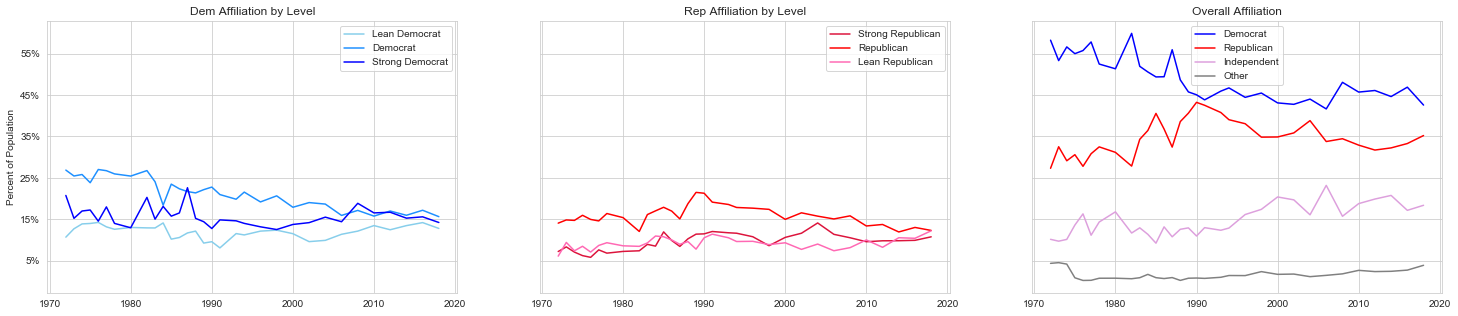

In [6]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(25,5))
ax1, ax2, ax3 = fig.subplots(nrows=1, ncols=3, sharey= True)
sns.lineplot(x= 'year', y = 'Lean Democrat', data= percent_parties, 
             color = 'skyblue', label= 'Lean Democrat', ax = ax1)
sns.lineplot(x= 'year', y = 'Democrat', data= percent_parties, 
             color = 'dodgerblue', label= 'Democrat', ax = ax1)
sns.lineplot(x= 'year', y = 'Strong Democrat', data= percent_parties, 
             color = 'blue', label= 'Strong Democrat', ax = ax1)
ax1.set_title('Dem Affiliation by Level')
ax1.set_ylabel('Percent of Population')
ax1.set_xlabel('')
sns.lineplot(x= 'year', y = 'Strong Republican', data= percent_parties, 
             color= 'crimson', label= 'Strong Republican', ax = ax2)
sns.lineplot(x= 'year', y = 'Republican', data= percent_parties, 
             color= 'red', label= 'Republican', ax = ax2)
sns.lineplot(x= 'year', y = 'Lean Republican', data= percent_parties, 
             color= 'hotpink', label= 'Lean Republican', ax = ax2);
ax2.set_title('Rep Affiliation by Level')
ax2.set_xlabel('')
sns.lineplot(x='year', y='Democrat', data=overall, 
             color= 'blue', label= 'Democrat', ax = ax3)
sns.lineplot(x='year', y='Republican', data=overall, 
             color= 'red', label= 'Republican', ax = ax3)
sns.lineplot(x='year', y='Independent', data=overall, 
             color= 'plum', label= 'Independent', ax = ax3)
sns.lineplot(x='year', y='Other', data=overall, 
             color= 'grey', label= 'Other', ax = ax3);
ax3.set_title('Overall Affiliation')
ax3.set_xlabel('')
plt.yticks(ticks=[.05, .15, .25, .35, .45, .55], 
           labels=['5%','15%', '25%', '35%', '45%', '55%']);

#### Time Series Forecasts
Overall by Party

In [7]:
party_aff_ovr = store_predictions(overall)
party_aff_ovr.to_excel('data/predictions/voter/overall.xlsx')

Within Party 

In [8]:
party_aff_lev = store_predictions(percent_parties)
party_aff_lev.to_excel('data/predictions/voter/leveled.xlsx')

In [9]:
party_aff_ovr

,Democrat,Predicted Democrat,Predicted Republican,Republican,Independent,Predicted Independent,Other,Predicted Other
1972,0.582501,NaN,NaN,0.272966,0.101286,NaN,0.043248,NaN
1973,0.533212,NaN,NaN,0.325005,0.096850,NaN,0.044933,NaN
1974,0.566261,NaN,NaN,0.291130,0.101148,NaN,0.041461,NaN
1975,0.549952,NaN,NaN,0.305847,0.135818,NaN,0.008382,NaN
1976,0.557456,NaN,NaN,0.277749,0.162836,NaN,0.001959,NaN
1977,0.578262,NaN,NaN,0.308168,0.111292,NaN,0.002278,NaN
1978,0.524851,NaN,NaN,0.324718,0.143141,NaN,0.007290,NaN
1980,0.513412,NaN,NaN,0.311503,0.167700,NaN,0.007385,NaN
1982,0.599026,NaN,NaN,0.278313,0.116573,NaN,0.006089,NaN
1983,0.519353,NaN,NaN,0.342957,0.129124,NaN,0.008566,NaN


#### Analysis- Party Affiliation

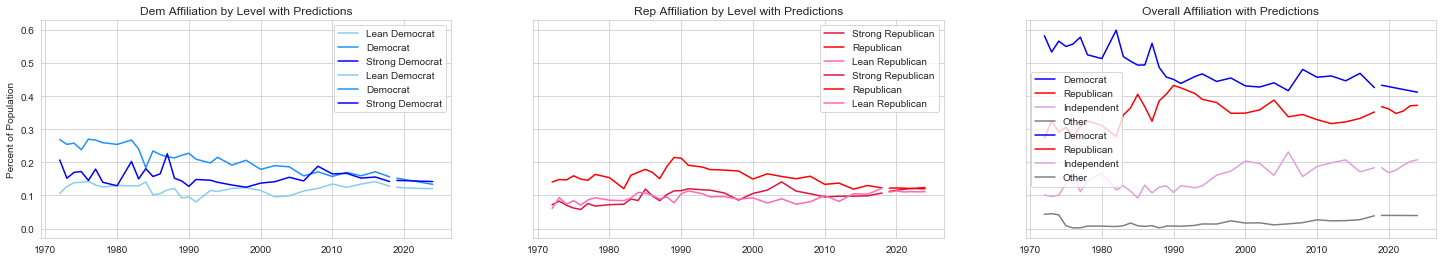

In [10]:
fig = plt.figure(figsize=(25,4))
ax1, ax2, ax3 = fig.subplots(nrows=1, ncols=3, sharey= True)
sns.lineplot(data= party_aff_lev['Lean Democrat'], 
             color = 'skyblue', label= 'Lean Democrat', ax = ax1)
sns.lineplot(data= party_aff_lev['Democrat'], 
             color = 'dodgerblue', label= 'Democrat', ax = ax1)
sns.lineplot(data= party_aff_lev['Strong Democrat'], 
             color = 'blue', label= 'Strong Democrat', ax = ax1)
sns.lineplot(data= party_aff_lev['Predicted Lean Democrat'], 
             color = 'skyblue', label= 'Lean Democrat', ax = ax1)
sns.lineplot(data= party_aff_lev['Predicted Democrat'], 
             color = 'dodgerblue', label= 'Democrat', ax = ax1)
sns.lineplot(data= party_aff_lev['Predicted Strong Democrat'], 
             color = 'blue', label= 'Strong Democrat', ax = ax1)
ax1.set_title('Dem Affiliation by Level with Predictions')
ax1.set_ylabel('Percent of Population')
ax1.set_xlabel('');
sns.lineplot(data= party_aff_lev['Strong Republican'], 
             color= 'crimson', label= 'Strong Republican', ax = ax2)
sns.lineplot(data= party_aff_lev['Republican'], 
             color= 'red', label= 'Republican', ax = ax2)
sns.lineplot(data= party_aff_lev['Lean Republican'], 
             color= 'hotpink', label= 'Lean Republican', ax = ax2)
sns.lineplot(data= party_aff_lev['Predicted Strong Republican'], 
             color= 'crimson', label= 'Strong Republican', ax = ax2)
sns.lineplot(data= party_aff_lev['Predicted Republican'], 
             color= 'red', label= 'Republican', ax = ax2)
sns.lineplot(data= party_aff_lev['Predicted Lean Republican'], 
             color= 'hotpink', label= 'Lean Republican', ax = ax2)
ax2.set_title('Rep Affiliation by Level with Predictions')
ax2.set_xlabel('')
sns.lineplot(data=party_aff_ovr['Democrat'], 
             color= 'blue', label= 'Democrat', ax = ax3)
sns.lineplot(data=party_aff_ovr['Republican'], 
             color= 'red', label= 'Republican', ax = ax3)
sns.lineplot(data=party_aff_ovr['Independent'], 
             color= 'plum', label= 'Independent', ax = ax3)
sns.lineplot(data=party_aff_ovr['Other'], 
             color= 'grey', label= 'Other', ax = ax3)
sns.lineplot(data=party_aff_ovr['Predicted Democrat'], 
             color= 'blue', label= 'Democrat', ax = ax3)
sns.lineplot(data=party_aff_ovr['Predicted Republican'], 
             color= 'red', label= 'Republican', ax = ax3)
sns.lineplot(data=party_aff_ovr['Predicted Independent'], 
             color= 'plum', label= 'Independent', ax = ax3)
sns.lineplot(data=party_aff_ovr['Predicted Other'], 
             color= 'grey', label= 'Other', ax = ax3)
ax3.set_title('Overall Affiliation with Predictions')
ax3.set_xlabel('');

Based on the projections it appears that party affiliation in America is trending toward more and more people identifying as independent. Meanwhile, within parties more and more people are identifying as Strong in their affiliation, even as affiliation with the party as a whole goes down.  

<hr style="border:3px solid gray"> </hr>

## Abortion Opinions

<hr style="border:3px solid gray"> </hr>

#### Clean

In [11]:
abortion = unzip('Abortion')
abortion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64814 entries, 0 to 64813
Data columns (total 9 columns):
year                                      64814 non-null int64
id                                        64814 non-null int32
Strong chance of serious defect           64814 non-null object
Married--wants no more children           64814 non-null object
Woman's health seriously endangered       64814 non-null object
Low income--cant afford more children     64814 non-null object
Pregnant as result of rape                64814 non-null object
Not married                               64814 non-null object
Abortion if woman wants for any reason    64814 non-null object
dtypes: int32(1), int64(1), object(7)
memory usage: 4.2+ MB


In [12]:
abortion.loc[(abortion['Strong chance of serious defect'] == 'Yes')|
             (abortion['Married--wants no more children'] == 'Yes')|
             (abortion["Woman's health seriously endangered"] == 'Yes')|
             (abortion["Low income--cant afford more children"] == 'Yes')|
             (abortion["Pregnant as result of rape"] == 'Yes')|
             (abortion['Not married']=='Yes'), 'abortion'] = 'conditional'
abortion.loc[(abortion['Strong chance of serious defect'] == 'Yes')&
             (abortion['Married--wants no more children'] == 'Yes')&
             (abortion["Woman's health seriously endangered"] == 'Yes')&
             (abortion["Low income--cant afford more children"] == 'Yes')&
             (abortion["Pregnant as result of rape"] == 'Yes')&
             (abortion['Not married']=='Yes'), 'abortion'] = 'unrestricted'
abortion.loc[(abortion['Strong chance of serious defect'] == 'No')&
             (abortion['Married--wants no more children'] == 'No')&
             (abortion["Woman's health seriously endangered"] == 'No')&
             (abortion["Low income--cant afford more children"] == 'No')&
             (abortion["Pregnant as result of rape"] == 'No')&
             (abortion['Not married']=='No'), 'abortion'] = 'never'
abortion.loc[abortion['Abortion if woman wants for any reason']== 'Yes', 'abortion']= 'unrestricted'
abortion.head()

,year,id,Strong chance of serious defect,Married--wants no more children,Woman's health seriously endangered,Low income--cant afford more children,Pregnant as result of rape,Not married,Abortion if woman wants for any reason,abortion
0,1972,0,Yes,Yes,Yes,Yes,Yes,Yes,Not applicable,unrestricted
1,1972,1,Yes,No,Yes,No,Yes,Yes,Not applicable,conditional
2,1972,2,Yes,Yes,Yes,Yes,Yes,Yes,Not applicable,unrestricted
3,1972,3,No,No,Yes,Yes,Yes,Yes,Not applicable,conditional
4,1972,4,Yes,Yes,Yes,Yes,Yes,Yes,Not applicable,unrestricted


In [13]:
abortion = abortion[['year','id', 'abortion']]
abortion = weight(abortion)
abortion_percentages = create_ts(abortion, ['unrestricted','conditional','never'])
abortion_percentages.head()

,year,unrestricted,conditional,never
0,1972,0.310454,0.608769,0.080777
1,1973,0.388621,0.561131,0.050248
2,1974,0.365500,0.589899,0.044602
3,1975,0.363598,0.576360,0.060042
4,1976,0.381581,0.563122,0.055298


#### EDA

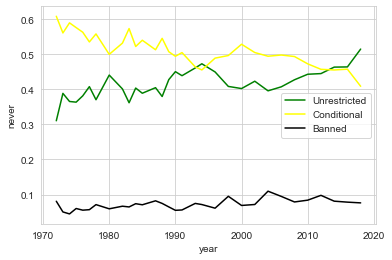

In [14]:
sns.lineplot(x= 'year', y= 'unrestricted', data= abortion_percentages, 
             color = 'green', label='Unrestricted')
sns.lineplot(x= 'year', y= 'conditional', data= abortion_percentages, 
             color= 'yellow', label='Conditional')
sns.lineplot(x= 'year', y= 'never', data= abortion_percentages, 
             color= 'black', label='Banned');

Over time, the percentage of people that favor unrestricted access to abortion has risen. Based on the graph it appears that most of those changed minds are people who previously favored conditional access.

#### Time Series Forecasts
Overall by Party

      abortion Predicted unrestricted  abortion unrestricted  \
1972                              NaN               0.053188   
1973                              NaN               0.044489   
1974                              NaN               0.023688   
1975                              NaN               0.041640   
1976                              NaN               0.019442   
1977                              NaN               0.054042   
1978                              NaN               0.013268   
1980                              NaN               0.008346   
1982                              NaN               0.024025   
1983                              NaN               0.049826   
1984                              NaN               0.030823   
1985                              NaN               0.028488   
1986                              NaN                    NaN   
1987                              NaN               0.004897   
1988                              NaN   

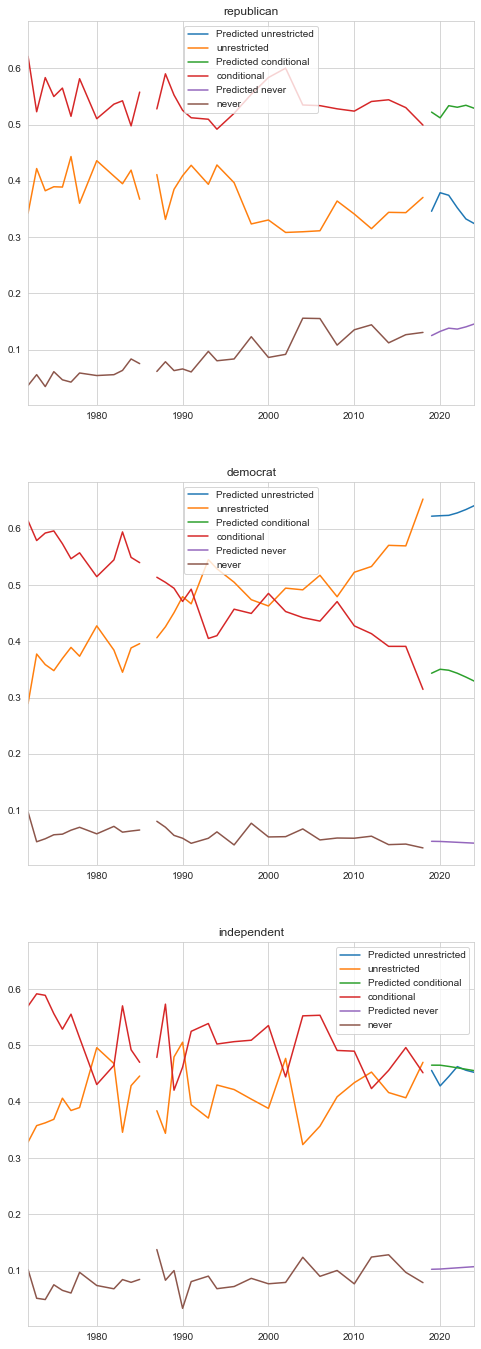

In [15]:
(rep_ts, dem_ts, ind_ts) = party_splits(abortion,['unrestricted', 
                                                  'conditional', 
                                                  'never'])
save('abortion', split='overall')

It appears that the major driver of the change I saw before is the democratic party, with some influence from independents. Interestingly, although we saw no change in the never stance overall, it appears that Republicans and independents are increasingly in favor of a complete ban.

Within Party

In [ ]:
(str_rep, mid_rep, ln_rep, 
 str_dem, mid_dem, ln_dem, 
 oth, ind) = party_splits(abortion, ['unrestricted', 
                                     'conditional', 
                                     'never'], split = 'within party')
save('abortion', split='within')

It appears that access to abortion is increasingly a part of party identity. As we can see, the gap in beliefs about access to abortion has been increasing, with Democrats more likely to support unrestricted access, Republicans most likely to support conditions on access, and banning access altogether. 

<hr style="border:3px solid gray"> </hr>

## Criminal Justice Attitudes

<hr style="border:3px solid gray"> </hr>

#### Clean

In [ ]:
crim_justice = unzip('Criminal_Justice')
crim_justice.columns

In [ ]:
(crim_justice[crim_justice['Ever approve of police striking citizen']=='Yes']
 ['Citizen attacking policeman with fists'].value_counts())

The police striking citizens columns lack information on how the police response is defined, and will likely be difficult to interpret given the nature of this analysis. Unfortunately I will have to drop them. 

In [ ]:
crim_justice.drop(['Citizen attacking policeman with fists', 
                   'Citizen attempting to escape custody', 
                   'Citizen questioned as murder suspect', 
                   'Citizen said vulgar or obscene things', 
                   'Ever approve of police striking citizen'], axis = 1, inplace = True)
crim_justice.rename(columns = {'Should marijuana be made legal': 'legalize_marijuana',
                             'Courts dealing with criminals': 'sentencing',
                             'Favor or oppose death penalty for murder': 'death_penalty', 
                             'Afraid to walk at night in neighborhood': 'fear'}, inplace=True)
crim_justice = weight(crim_justice)

<hr style="border:2px solid gray"> </hr>

### Legalization of Marijuana
#### EDA

In [ ]:
crim_justice['legalize_marijuana'].unique()

In [ ]:
marijuana = crim_justice[['year', 'legalize_marijuana']]
marijuana_percentages = create_ts(marijuana, ['Legal', 'Not legal'])
marijuana_percentages.set_index('year').plot();

Clearly, attitudes about legalization of marijuana have shifted from prohibition to legalization.

#### Time Series Forecasts
Overall by Party

In [ ]:
rep_ts, dem_ts, ind_ts = party_splits(marijuana, ['Legal',
                                                     'Not legal'])
save('crim_justice/marijuana', split='overall')

Clearly, attitudes about the legalization of marijuana have changed in favor of legalization, with Democrats leading the way. 

Within Party

In [ ]:
(str_rep, mid_rep, ln_rep, 
 str_dem, mid_dem, ln_dem, 
 oth, ind) = party_splits(marijuana, ['Legal', 
                                     'Not legal'], split = 'within party')
save('crim_justice/marijuana', split='within')

<hr style="border:2px solid gray"> </hr>

### Criminal Sentencing
#### EDA

In [ ]:
crim_justice['sentencing'].unique()

In [ ]:
sentencing = crim_justice[['year', 'sentencing']]
sentencing_percentages = create_ts(sentencing, ['About right', 
                                                'Not harsh enough', 
                                                'Too harsh'])
sentencing_percentages.set_index('year').plot();

#### Time Series Forecasts
Overall by Party

In [ ]:
rep_ts, dem_ts, ind_ts = party_splits(sentencing, ['About right',
                                                   'Not harsh enough', 
                                                   'Too harsh'])
save('crim_justice/sentencing', split= 'overall')

Over time attitudes about sentencing are changing. They are changing more quickly amongst independents and democrats. In addition, while more democrats are saying that it is too harsh, repuclicans are more likely to say that sentencing is about right.

Within Party

In [ ]:
(str_rep, mid_rep, ln_rep, 
 str_dem, mid_dem, ln_dem, 
 oth, ind) = party_splits(sentencing, ['About right',
                                       'Not harsh enough', 
                                       'Too harsh'], split='within party')
save('crim_justice/sentencing', split='within')

<hr style="border:3px solid gray"> </hr>

### Death Penalty
#### EDA

In [ ]:
crim_justice['death_penalty'].unique()

In [ ]:
death_penalty = crim_justice[['year', 'death_penalty']]
death_penalty_percentages = create_ts(death_penalty, ['Favor',
                                                      'Oppose'])
death_penalty_percentages.set_index('year').plot();
death_penalty_preds = store_predictions(death_penalty_percentages)

In [ ]:
death_penalty_preds.to_excel('data/predictions/crim_justice/death_penalty/USpop.xlsx')

#### Time Series Forecasts
Overall by Party

In [ ]:
rep_ts, dem_ts, ind_ts = party_splits(death_penalty, ['Favor',
                                                      'Oppose'])
save('crim_justice/death_penalty', split='overall')

Within Party

In [ ]:
(str_rep, mid_rep, ln_rep, 
 str_dem, mid_dem, ln_dem, 
 oth, ind) = party_splits(death_penalty, ['Favor',
                                          'Oppose'], split='within party')
save('crim_justice/death_penalty', split='within')

<hr style="border:3px solid gray"> </hr>

## Gender and Sexuality

<hr style="border:3px solid gray"> </hr>

#### Cleaning 

In [ ]:
gender = unzip('Gender_and_Sexuality')
gender.columns

In [ ]:
gender.drop(['Should hire and promote women                            ', 
             'For or against preferential hiring of women      ', 
             'Better for man to work, woman tend home', 'Preschool kids suffer if mother works',
             'Sex before marriage -- teens 14-16', 'Birth control to teenagers 14-16'], 
            axis = 1, inplace = True)
gender.rename(columns ={'Sex before marriage':'sex_before_marr',
                        'Divorce laws': 'divorce', 
                        'Sex education in public schools':'sex_ed',
                        'Women not suited for politics': 'no_women_pol',
                        'Homosexuals should have right to marry':'gay_marr'}, inplace=True)
gender = weight(gender)

<hr style="border:2px solid gray"> </hr>

### Divorce Laws
#### EDA

In [ ]:
gender['divorce'].unique()

In [ ]:
divorce = gender[['year', 'divorce']]
divorce_percentages = create_ts(divorce, ['More difficult',
                                        'Stay same','Easier'])
divorce_percentages.set_index('year').plot();

#### Time Series Forecasts
Overall by party

In [ ]:
rep_ts, dem_ts, ind_ts = party_splits(divorce, ['More difficult',
                                        'Stay same','Easier'])
save('gender/divorce', split='overall')

Within Party

In [ ]:
(str_rep, mid_rep, ln_rep, 
 str_dem, mid_dem, ln_dem, 
 oth, ind) = party_splits(divorce, ['More difficult',
                                        'Stay same','Easier'], split='within party')
save('gender/divorce', split='within')

<hr style="border:2px solid gray"> </hr>

### Gay Marriage
#### EDA

In [ ]:
gender.loc[(gender['gay_marr']=='Neither agree nor disagree')|
           (gender['gay_marr']=='Cant choose'), 'gay_marr']= 'undecided'
gender['gay_marr'].unique()

In [ ]:
gay_marr = gender[['year', 'gay_marr']]
gay_marr_percentages = create_ts(gay_marr, ['Strongly disagree',
                                            'undecided',
                                            'Disagree',
                                            'Agree',
                                            'Strongly agree'])
gay_marr_percentages.set_index('year').plot();

#### Time Series Forecasts
Overall by Party

In [ ]:
rep_ts, dem_ts, ind_ts = party_splits(gay_marr, ['Strongly disagree', 
                                                 'undecided',
                                                 'Disagree',
                                                 'Agree', 
                                                 'Strongly agree'])
save('gender/gay_marr', split='overall')

Within Party

In [ ]:
(str_rep, mid_rep, ln_rep, 
 str_dem, mid_dem, ln_dem, 
 oth, ind) = party_splits(gay_marr, ['Strongly disagree', 
                                     'undecided',
                                     'Disagree',
                                     'Agree', 
                                     'Strongly agree'], split='within party')
save('gender/gay_marr', split='within')

<hr style="border:3px solid gray"> </hr>

## Race Relations

<hr style="border:3px solid gray"> </hr>

#### Cleaning

In [ ]:
race = unzip('Race_Relations')
race.columns

Because of the ways in which these variables were coded, many of them are either redundant with other questions, or difficult to gain meaningful information from.  

In [ ]:
race.drop(['Hard working - lazy', 'Hard working - lazy.1', 
           'Rich - poor', 'Rich - poor.1', 'Blacks overcome prejudice without favors ',
           'Any opp. race in neighborhood', 'Favor law against racial intermarriage', 
           'Improving the conditions of blacks'], axis = 1, inplace = True)
race.loc[race['Should govt aid blacks?']=='Agree with both', 'Should govt aid blacks?']= 'no opinion'
race.loc[race['Should govt aid blacks?']=='No special treatment', 'Should govt aid blacks?']= 'strongly oppose'
race.loc[race['Should govt aid blacks?']== 4, 'Should govt aid blacks?']= 'oppose'
race.loc[race['Should govt aid blacks?']=='Govt help blks', 'Should govt aid blacks?']= 'strongly favor'
race.loc[race['Should govt aid blacks?']== 2, 'Should govt aid blacks?']= 'favor'
race.loc[race['Should govt aid blacks?']=="Don't know", 'Should govt aid blacks?']= 'no opinion'
race.loc[race['Should govt aid blacks?']=="No answer", 'Should govt aid blacks?']= 'no opinion'
race = weight(race)
race.columns

In [ ]:
race.rename(columns ={'Whites hurt by aff. action':'aff_action_hurts_whites',
                      'Should govt aid blacks?': 'aid_blacks', 
                      'Differences due to lack of will':'willpower',
                      'Differences due to lack of education': 'education',
                      'Differences due to inborn disability':'inborn',
                      'Differences due to discrimination':'discrimination',
                      'Favor preference in hiring blacks':'aff_action',
                      'Number of immigrants nowadays should be':'immigration'}, inplace=True)

<hr style="border:2px solid gray"> </hr>

### Differences in Status are due to lack of will
#### EDA

In [ ]:
race['willpower'].unique()

In [ ]:
willpower = race[['year', 'willpower']]
willpower_percentages = create_ts(willpower, ['Yes',
                                              'No'])
willpower_percentages.set_index('year').plot();

#### Time Series Forecasts
Overall by party

In [ ]:
rep_ts, dem_ts, ind_ts = party_splits(willpower, ['Yes',
                                                  'No'])
save('inequality/willpower', split='overall')

Within Party

In [ ]:
(str_rep, mid_rep, ln_rep, 
 str_dem, mid_dem, ln_dem, 
 oth, ind) = party_splits(willpower, ['Yes',
                                            'No'], split='within party')
save('inequality/willpower', split='within')

<hr style="border:2px solid gray"> </hr>

### Differences in Status are due to lack of education
#### EDA

In [ ]:
race['education'].unique()

In [ ]:
education = race[['year', 'education']]
education_percentages = create_ts(education, ['Yes',
                                              'No'])
education_percentages.set_index('year').plot();

#### Time Series Forecasts
Overall by party

In [ ]:
rep_ts, dem_ts, ind_ts = party_splits(education, ['Yes',
                                                  'No'])
save('inequality/education', split='overall')

Within Party

In [ ]:
(str_rep, mid_rep, ln_rep, 
 str_dem, mid_dem, ln_dem, 
 oth, ind) = party_splits(education, ['Yes',
                                      'No'], split='within party')
save('inequality/education', split='within')

<hr style="border:2px solid gray"> </hr>

### Differences in Status are due to 'inborn disability'
#### EDA

In [ ]:
race['inborn'].unique()

In [ ]:
inborn = race[['year', 'inborn']]
inborn_percentages = create_ts(inborn, ['YES',
                                        'NO'])
inborn_percentages.set_index('year').plot();

#### Time Series Forecasts
Overall by party

In [ ]:
rep_ts, dem_ts, ind_ts = party_splits(inborn, ['YES',
                                               'NO'])
save('inequality/inborn', split='overall')

Within Party

In [ ]:
(str_rep, mid_rep, ln_rep, 
 str_dem, mid_dem, ln_dem, 
 oth, ind) = party_splits(inborn, ['YES',
                                   'NO'], split='within party')
save('inequality/inborn', split='within')

<hr style="border:2px solid gray"> </hr>

### Differences in Status are due to discrimination
#### EDA

In [ ]:
race['discrimination'].unique()

In [ ]:
discrimination = race[['year', 'discrimination']]
discrimination_percentages = create_ts(discrimination, ['Yes',
                                                        'No'])
discrimination_percentages.set_index('year').plot();

#### Time Series Forecasts
Overall by party

In [ ]:
rep_ts, dem_ts, ind_ts = party_splits(discrimination, ['Yes',
                                                       'No'])
save('inequality/discrimination', split='overall')

Within Party

In [ ]:
(str_rep, mid_rep, ln_rep, 
 str_dem, mid_dem, ln_dem, 
 oth, ind) = party_splits(discrimination, ['Yes',
                                           'No'], split='within party')
save('inequality/discrimination', split='within')

<hr style="border:2px solid gray"> </hr>

### Are whites hurt by affirmative action?
#### EDA

In [ ]:
race['aff_action_hurts_whites'].unique()

In [ ]:
aff_act_hrt_wht = race[['year', 'aff_action_hurts_whites']]
aff_act_hrt_wht_percentages = create_ts(aff_act_hrt_wht, ['Somewhat likely',
                                                          'Very likely',
                                                          'Not very likely'])
aff_act_hrt_wht_percentages.set_index('year').plot();

#### Time Series Forecasts
Overall by Party

In [ ]:
rep_ts, dem_ts, ind_ts = party_splits(aff_act_hrt_wht, ['Somewhat likely',
                                                        'Very likely',
                                                        'Not very likely'])
save('race/aff_act_hrt_wht', split='overall')

Within Party

In [ ]:
(str_rep, mid_rep, ln_rep, 
 str_dem, mid_dem, ln_dem, 
 oth, ind) = party_splits(aff_act_hrt_wht, ['Somewhat likely',
                                            'Very likely',
                                            'Not very likely'], split='within party')
save('race/aff_act_hrt_wht', split='within')

<hr style="border:2px solid gray"> </hr>

### Should the Government provide aid to black people?
#### EDA

In [ ]:
race['aid_blacks'].unique()

In [ ]:
race.loc[race['aid_blacks']== '2', 'aid_blacks']='favor'
race.loc[race['aid_blacks']=='4', 'aid_blacks']='oppose'

In [ ]:
aid_blacks = race[['year', 'aid_blacks']]
aid_blacks_percentages = create_ts(aid_blacks, ['no opinion',
                                                'strongly oppose',
                                                'strongly favor',
                                                'favor', 
                                                'oppose'])
aid_blacks_percentages.set_index('year').plot();

#### Time Series Forecasts
Overall by Party

In [ ]:
rep_ts, dem_ts, ind_ts = party_splits(aid_blacks, ['no opinion',
                                                   'strongly oppose',
                                                   'strongly favor',
                                                   'favor', 
                                                   'oppose'])
save('race/aid_blacks', split='overall')

Within Party

In [ ]:
(str_rep, mid_rep, ln_rep, 
 str_dem, mid_dem, ln_dem, 
 oth, ind) = party_splits(aid_blacks, ['no opinion',
                                       'strongly oppose',
                                       'strongly favor',
                                       'favor', 
                                       'oppose'], split='within party')
save('race/aid_blacks', split='within')

<hr style="border:2px solid gray"> </hr>

### Support for Preferential Hiring of black people
#### EDA 

In [ ]:
race['aff_action'].unique()

In [ ]:
aff_action = race[['year', 'aff_action']]
aff_action_percentages = create_ts(aff_action, ['Strongly support pref',
                                                'Strongly oppose pref',
                                                'Support pref',
                                                'Oppose pref'])
aff_action_percentages.set_index('year').plot();

#### Time Series Forecasts
Overall by party

In [ ]:
rep_ts, dem_ts, ind_ts = party_splits(aff_action, ['Strongly support pref',
                                                   'Strongly oppose pref',
                                                   'Support pref',
                                                   'Oppose pref'])
save('race/aff_action', split='overall')

Within Party

In [ ]:
(str_rep, mid_rep, ln_rep, 
 str_dem, mid_dem, ln_dem, 
 oth, ind) = party_splits(aff_action, ['Strongly support pref',
                                       'Strongly oppose pref',
                                       'Support pref',
                                       'Oppose pref'], split='within party')
save('race/aff_action', split='within')

<hr style="border:2px solid gray"> </hr>

### Immigration Numbers
#### EDA 

In [ ]:
race['immigration'].unique()

In [ ]:
immigration = race[['year', 'immigration']]
immigration_percentages = create_ts(immigration, ['Increased a lot',
                                                  'Remain the same as it is',
                                                  'Reduced a lot, or',
                                                  'Reduced a little',
                                                  'Increased a little'])
immigration_percentages.set_index('year').plot();

#### Time Series Forecasts
Overall by party

In [ ]:
rep_ts, dem_ts, ind_ts = party_splits(immigration, ['Increased a lot',
                                                    'Remain the same as it is',
                                                    'Reduced a lot, or',
                                                    'Reduced a little',
                                                    'Increased a little'])
save('race/immigration', split='overall')

Within Party

In [ ]:
(str_rep, mid_rep, ln_rep, 
 str_dem, mid_dem, ln_dem, 
 oth, ind) = party_splits(immigration, ['Increased a lot',
                                        'Remain the same as it is',
                                        'Reduced a lot, or',
                                        'Reduced a little',
                                        'Increased a little'], split='within party')
save('race/immigration', split='within')

<hr style="border:3px solid gray"> </hr>

## Government Spending

<hr style="border:3px solid gray"> </hr>

#### Cleaning

In [ ]:
spending = unzip('Opinions')
spending.columns

In [ ]:
spending.rename(columns ={'Foreign aid':'foreign_aid',
                          'Welfare': 'welfare', 
                          'Highways and bridges':'infastructure',
                          'Social security': 'social_sec',
                          'Mass transportation':'mass_transit',
                          'Parks and recreation':'parks_rec',
                          'Assistance for childcare':'childcare',
                          'Supporting scientific research        ':'research',
                          'Military, armaments, and defense':'military',
                          'Improving the conditions of blacks':'inequality',
                          'Space exploration program':'space_explore',
                          'Improving & protecting environment':'environment',
                          'Improving & protecting nations health':'healthcare',
                          'Solving problems of big cities':'urban',
                          'Halting rising crime rate':'crime',
                          'Dealing with drug addiction':'addiction',
                          'Improving nations education system':'education',
                          'Developing alternative energy sources':'alt_energy'}, inplace=True)

In [ ]:
spending = weight(spending)

<hr style="border:2px solid gray"> </hr>

### Foreign aid
#### EDA

In [ ]:
spending['foreign_aid'].unique()

In [ ]:
foreign_aid = spending[['year', 'foreign_aid']]
foreign_aid_percentages = create_ts(foreign_aid, ['Too much',
                                                  'About right',
                                                  'Too little'])
foreign_aid_percentages.set_index('year').plot();

#### Time Series Forecasts
Overall by party

In [ ]:
rep_ts, dem_ts, ind_ts = party_splits(foreign_aid, ['Too much',
                                                    'About right',
                                                    'Too little'])
save('spending/foreign_aid', split='overall')

Within Party

In [ ]:
(str_rep, mid_rep, ln_rep, 
 str_dem, mid_dem, ln_dem, 
 oth, ind) = party_splits(foreign_aid, ['Too much',
                                        'About right',
                                        'Too little'], split='within party')
save('spending/foreign_aid', split='within')

<hr style="border:2px solid gray"> </hr>

### Welfare
#### EDA

In [ ]:
spending['welfare'].unique()

In [ ]:
welfare = spending[['year', 'welfare']]
welfare_percentages = create_ts(welfare, ['Too much',
                                                  'About right',
                                                  'Too little'])
welfare_percentages.set_index('year').plot();

#### Time Series Forecasts
Overall by party

In [ ]:
rep_ts, dem_ts, ind_ts = party_splits(welfare, ['Too much',
                                                    'About right',
                                                    'Too little'])
save('spending/welfare', split='overall')

Within Party

In [ ]:
(str_rep, mid_rep, ln_rep, 
 str_dem, mid_dem, ln_dem, 
 oth, ind) = party_splits(welfare, ['Too much',
                                        'About right',
                                        'Too little'], split='within party')
save('spending/welfare', split='within')

<hr style="border:2px solid gray"> </hr>

### Highways and bridges
#### EDA

In [ ]:
infastructure = spending[['year', 'infastructure']]
infastructure_percentages = create_ts(infastructure, ['Too much',
                                                  'About right',
                                                  'Too little'])
infastructure_percentages.set_index('year').plot();

#### Time Series Forecasts
Overall by party

In [ ]:
rep_ts, dem_ts, ind_ts = party_splits(infastructure, ['Too much',
                                                    'About right',
                                                    'Too little'])
save('spending/infastructure', split='overall')

Within Party

In [ ]:
(str_rep, mid_rep, ln_rep, 
 str_dem, mid_dem, ln_dem, 
 oth, ind) = party_splits(infastructure, ['Too much',
                                        'About right',
                                        'Too little'], split='within party')
save('spending/infastructure', split='within')

<hr style="border:2px solid gray"> </hr>

### Social Security
#### EDA

In [ ]:
social_sec = spending[['year', 'social_sec']]
social_sec_percentages = create_ts(social_sec, ['Too much',
                                                  'About right',
                                                  'Too little'])
social_sec_percentages.set_index('year').plot();

#### Time Series Forecasts
Overall by party

In [ ]:
rep_ts, dem_ts, ind_ts = party_splits(social_sec, ['Too much',
                                                    'About right',
                                                    'Too little'])
save('spending/social_sec', split='overall')

Within Party

In [ ]:
(str_rep, mid_rep, ln_rep, 
 str_dem, mid_dem, ln_dem, 
 oth, ind) = party_splits(social_sec, ['Too much',
                                        'About right',
                                        'Too little'], split='within party')
save('spending/social_sec', split='within')

<hr style="border:2px solid gray"> </hr>

### Mass transportation
#### EDA

In [ ]:
mass_transit = spending[['year', 'mass_transit']]
mass_transit_percentages = create_ts(mass_transit, ['Too much',
                                                  'About right',
                                                  'Too little'])
mass_transit_percentages.set_index('year').plot();

#### Time Series Forecasts
Overall by party

In [ ]:
rep_ts, dem_ts, ind_ts = party_splits(mass_transit, ['Too much',
                                                    'About right',
                                                    'Too little'])
save('spending/mass_transit', split='overall')

Within Party

In [ ]:
(str_rep, mid_rep, ln_rep, 
 str_dem, mid_dem, ln_dem, 
 oth, ind) = party_splits(mass_transit, ['Too much',
                                        'About right',
                                        'Too little'], split='within party')
save('spending/mass_transit', split='within')

<hr style="border:2px solid gray"> </hr>

### Parks and recreation
#### EDA

In [ ]:
parks_rec = spending[['year', 'parks_rec']]
parks_rec_percentages = create_ts(parks_rec, ['Too much',
                                                  'About right',
                                                  'Too little'])
parks_rec_percentages.set_index('year').plot();

#### Time Series Forecasts
Overall by party

In [ ]:
rep_ts, dem_ts, ind_ts = party_splits(parks_rec, ['Too much',
                                                    'About right',
                                                    'Too little'])
save('spending/parks_rec', split='overall')

Within Party

In [ ]:
(str_rep, mid_rep, ln_rep, 
 str_dem, mid_dem, ln_dem, 
 oth, ind) = party_splits(parks_rec, ['Too much',
                                        'About right',
                                        'Too little'], split='within party')
save('spending/parks_rec', split='within')

<hr style="border:2px solid gray"> </hr>

### Assistance for childcare
#### EDA

In [ ]:
childcare = spending[['year', 'childcare']]
childcare_percentages = create_ts(childcare, ['Too much',
                                                  'About right',
                                                  'Too little'])
childcare_percentages.set_index('year').plot();

#### Time Series Forecasts
Overall by party

In [ ]:
rep_ts, dem_ts, ind_ts = party_splits(childcare, ['Too much',
                                                    'About right',
                                                    'Too little'])
save('spending/childcare', split='overall')

Within Party

In [ ]:
(str_rep, mid_rep, ln_rep, 
 str_dem, mid_dem, ln_dem, 
 oth, ind) = party_splits(childcare, ['Too much',
                                        'About right',
                                        'Too little'], split='within party')
save('spending/childcare', split='within')

<hr style="border:2px solid gray"> </hr>

### Supporting scientific research
#### EDA

In [ ]:
research = spending[['year', 'research']]
research_percentages = create_ts(research, ['Too much',
                                                  'About right',
                                                  'Too little'])
research_percentages.set_index('year').plot();

#### Time Series Forecasts
Overall by party

In [ ]:
rep_ts, dem_ts, ind_ts = party_splits(research, ['Too much',
                                                    'About right',
                                                    'Too little'])
save('spending/research', split='overall')

Within Party

In [ ]:
(str_rep, mid_rep, ln_rep, 
 str_dem, mid_dem, ln_dem, 
 oth, ind) = party_splits(research, ['Too much',
                                        'About right',
                                        'Too little'], split='within party')
save('spending/research', split='within')

<hr style="border:2px solid gray"> </hr>

### Military, armaments, and defense
#### EDA

In [ ]:
military = spending[['year', 'military']]
military_percentages = create_ts(military, ['Too much',
                                                  'About right',
                                                  'Too little'])
military_percentages.set_index('year').plot();

#### Time Series Forecasts
Overall by party

In [ ]:
rep_ts, dem_ts, ind_ts = party_splits(military, ['Too much',
                                                    'About right',
                                                    'Too little'])
save('spending/military', split='overall')

Within Party

In [ ]:
(str_rep, mid_rep, ln_rep, 
 str_dem, mid_dem, ln_dem, 
 oth, ind) = party_splits(military, ['Too much',
                                        'About right',
                                        'Too little'], split='within party')
save('spending/military', split='within')

<hr style="border:2px solid gray"> </hr>

### Improving Racial Equality
#### EDA

In [ ]:
inequality = spending[['year', 'inequality']]
inequality_percentages = create_ts(inequality, ['Too much',
                                                  'About right',
                                                  'Too little'])
inequality_percentages.set_index('year').plot();

#### Time Series Forecasts
Overall by party

In [ ]:
rep_ts, dem_ts, ind_ts = party_splits(inequality, ['Too much',
                                                    'About right',
                                                    'Too little'])
save('spending/inequality', split='overall')

Within Party

In [ ]:
(str_rep, mid_rep, ln_rep, 
 str_dem, mid_dem, ln_dem, 
 oth, ind) = party_splits(inequality, ['Too much',
                                        'About right',
                                        'Too little'], split='within party')
save('spending/inequality', split='within')

<hr style="border:2px solid gray"> </hr>

### Space exploration program
#### EDA

In [ ]:
space_explore = spending[['year', 'space_explore']]
space_explore_percentages = create_ts(space_explore, ['Too much',
                                                  'About right',
                                                  'Too little'])
space_explore_percentages.set_index('year').plot();

#### Time Series Forecasts
Overall by party

In [ ]:
rep_ts, dem_ts, ind_ts = party_splits(space_explore, ['Too much',
                                                    'About right',
                                                    'Too little'])
save('spending/space_explore', split='overall')

Within Party

In [ ]:
(str_rep, mid_rep, ln_rep, 
 str_dem, mid_dem, ln_dem, 
 oth, ind) = party_splits(space_explore, ['Too much',
                                        'About right',
                                        'Too little'], split='within party')
save('spending/space_explore', split='within')

<hr style="border:2px solid gray"> </hr>

### Improving & protecting environment
#### EDA

In [ ]:
environment = spending[['year', 'environment']]
environment_percentages = create_ts(environment, ['Too much',
                                                  'About right',
                                                  'Too little'])
environment_percentages.set_index('year').plot();

#### Time Series Forecasts
Overall by party

In [ ]:
rep_ts, dem_ts, ind_ts = party_splits(environment, ['Too much',
                                                    'About right',
                                                    'Too little'])
save('spending/environment', split='overall')

Within Party

In [ ]:
(str_rep, mid_rep, ln_rep, 
 str_dem, mid_dem, ln_dem, 
 oth, ind) = party_splits(environment, ['Too much',
                                        'About right',
                                        'Too little'], split='within party')
save('spending/environment', split='within')

<hr style="border:2px solid gray"> </hr>

### Improving & protecting nations health
#### EDA

In [ ]:
healthcare = spending[['year', 'healthcare']]
healthcare_percentages = create_ts(healthcare, ['Too much',
                                                  'About right',
                                                  'Too little'])
healthcare_percentages.set_index('year').plot();

#### Time Series Forecasts
Overall by party

In [ ]:
rep_ts, dem_ts, ind_ts = party_splits(healthcare, ['Too much',
                                                    'About right',
                                                    'Too little'])
save('spending/healthcare', split='overall')

Within Party

In [ ]:
(str_rep, mid_rep, ln_rep, 
 str_dem, mid_dem, ln_dem, 
 oth, ind) = party_splits(healthcare, ['Too much',
                                        'About right',
                                        'Too little'], split='within party')
save('spending/healthcare', split='within')

<hr style="border:2px solid gray"> </hr>

### Solving problems of big cities
#### EDA

In [ ]:
urban = spending[['year', 'urban']]
urban_percentages = create_ts(urban, ['Too much',
                                                  'About right',
                                                  'Too little'])
urban_percentages.set_index('year').plot();

#### Time Series Forecasts
Overall by party

In [ ]:
rep_ts, dem_ts, ind_ts = party_splits(urban, ['Too much',
                                                    'About right',
                                                    'Too little'])
save('spending/urban', split='overall')

Within Party

In [ ]:
(str_rep, mid_rep, ln_rep, 
 str_dem, mid_dem, ln_dem, 
 oth, ind) = party_splits(urban, ['Too much',
                                        'About right',
                                        'Too little'], split='within party')
save('spending/urban', split='within')

<hr style="border:2px solid gray"> </hr>

### Halting rising crime rate
#### EDA

In [ ]:
crime = spending[['year', 'crime']]
crime_percentages = create_ts(crime, ['Too much',
                                                  'About right',
                                                  'Too little'])
crime_percentages.set_index('year').plot();

#### Time Series Forecasts
Overall by party

In [ ]:
rep_ts, dem_ts, ind_ts = party_splits(crime, ['Too much',
                                                    'About right',
                                                    'Too little'])
save('spending/crime', split='overall')

Within Party

In [ ]:
(str_rep, mid_rep, ln_rep, 
 str_dem, mid_dem, ln_dem, 
 oth, ind) = party_splits(crime, ['Too much',
                                        'About right',
                                        'Too little'], split='within party')
save('spending/crime', split='within')

<hr style="border:2px solid gray"> </hr>

### Dealing with drug addiction
#### EDA

In [ ]:
addiction = spending[['year', 'addiction']]
addiction_percentages = create_ts(addiction, ['Too much',
                                                  'About right',
                                                  'Too little'])
addiction_percentages.set_index('year').plot();

#### Time Series Forecasts
Overall by party

In [ ]:
rep_ts, dem_ts, ind_ts = party_splits(addiction, ['Too much',
                                                    'About right',
                                                    'Too little'])
save('spending/addiction', split='overall')

Within Party

In [ ]:
(str_rep, mid_rep, ln_rep, 
 str_dem, mid_dem, ln_dem, 
 oth, ind) = party_splits(addiction, ['Too much',
                                        'About right',
                                        'Too little'], split='within party')
save('spending/addiction', split='within')

<hr style="border:2px solid gray"> </hr>

### Improving nations education system
#### EDA

In [ ]:
education = spending[['year', 'education']]
education_percentages = create_ts(education, ['Too much',
                                                  'About right',
                                                  'Too little'])
education_percentages.set_index('year').plot();

#### Time Series Forecasts
Overall by party

In [ ]:
rep_ts, dem_ts, ind_ts = party_splits(education, ['Too much',
                                                    'About right',
                                                    'Too little'])
save('spending/education', split='overall')

Within Party

In [ ]:
(str_rep, mid_rep, ln_rep, 
 str_dem, mid_dem, ln_dem, 
 oth, ind) = party_splits(education, ['Too much',
                                        'About right',
                                        'Too little'], split='within party')
save('spending/education', split='within')

<hr style="border:2px solid gray"> </hr>

### Developing alternative energy sources
#### EDA

In [ ]:
alt_energy = spending[['year', 'alt_energy']]
alt_energy_percentages = create_ts(alt_energy, ['Too much',
                                                  'About right',
                                                  'Too little'])
alt_energy_percentages.set_index('year').plot();

#### Time Series Forecasts
Overall by party

In [ ]:
rep_ts, dem_ts, ind_ts = party_splits(alt_energy, ['Too much',
                                                    'About right',
                                                    'Too little'])
save('spending/alt_energy', split='overall')

Within Party

In [ ]:
(str_rep, mid_rep, ln_rep, 
 str_dem, mid_dem, ln_dem, 
 oth, ind) = party_splits(alt_energy, ['Too much',
                                        'About right',
                                        'Too little'], split='within party')
save('spending/alt_energy', split='within')

# Demographics

In [ ]:
pers_id = unzip('Identity')
pers_id.columns

In [ ]:
for col in pers_id.columns:
    print(pers_id[col].value_counts())
    print('\n')

In [ ]:
pers_id.rename(columns={'Age of respondent':'age', 
                      'Respondents sex':'sex', 
                      'Race of respondent':'race',
                      'Region of interview':'region'}, inplace = True)

In [ ]:
pers_id = weight(pers_id)

<hr style="border:2px solid gray"> </hr>

### Age
#### EDA

In [ ]:
age = pers_id[['year', 'age']]
age = age[age['age']!="Don't know"]
age = age[age['age']!='No answer']
age['party']= party['party']
print(age['age'].min())
print(age['age'].max())

In [ ]:
age.head()

In [ ]:
age.loc[age['age']=='89 or older', 'age']= 89
age.loc[age['age']=='75 or older', 'age']= 75
age['age'] = age['age'].astype(int)
age.loc[age['age']<25, 'age_group']= 'under 25'
age.loc[(age['age']>=25) &
    (age['age']<35), 'age_group']= '25 to 34'
age.loc[(age['age']>=35) &
    (age['age']<45), 'age_group']= '35 to 44'
age.loc[(age['age']>=45) &
    (age['age']<55), 'age_group']= '45 to 54'
age.loc[(age['age']>=55) &
    (age['age']<65), 'age_group']= '55 to 64'
age.loc[(age['age']>=65) &
    (age['age']<75), 'age_group']= '65 to 74'
age.loc[(age['age']>=75), 'age_group'] = '75 or over'

age['age_group'].value_counts()

In [ ]:
u_25 = age.loc[age['age_group']== 'under 25']
u_25 = u_25[['year', 'party']]
u_25_percentages = create_ts(u_25, parties)
party_aff_ovr_u_25 = store_predictions(u_25_percentages)
party_aff_ovr_u_25.to_excel('data/predictions/demographics/age/u_25.xlsx')

In [ ]:
u_35 = age.loc[age['age_group']== '25 to 34']
u_35 = u_35[['year', 'party']]
u_35_percentages = create_ts(u_35, parties)
party_aff_ovr_u_35 = store_predictions(u_35_percentages)
party_aff_ovr_u_35.to_excel('data/predictions/demographics/age/u_35.xlsx')

In [ ]:
u_45 = age.loc[age['age_group']== '35 to 44']
u_45 = u_45[['year', 'party']]
u_45_percentages = create_ts(u_45, parties)
party_aff_ovr_u_45 = store_predictions(u_45_percentages)
party_aff_ovr_u_45.to_excel('data/predictions/demographics/age/u_45.xlsx')

In [ ]:
u_55 = age.loc[age['age_group']== '45 to 54']
u_55 = u_55[['year', 'party']]
u_55_percentages = create_ts(u_55, parties)
party_aff_ovr_u_55 = store_predictions(u_55_percentages)
party_aff_ovr_u_55.to_excel('data/predictions/demographics/age/u_55.xlsx')

In [ ]:
u_65 = age.loc[age['age_group']== '55 to 64']
u_65 = u_65[['year', 'party']]
u_65_percentages = create_ts(u_65, parties)
party_aff_ovr_u_65 = store_predictions(u_65_percentages)
party_aff_ovr_u_65.to_excel('data/predictions/demographics/age/u_65.xlsx')

In [ ]:
u_75 = age.loc[age['age_group']== '65 to 74']
u_75 = u_75[['year', 'party']]
u_75_percentages = create_ts(u_75, parties)
party_aff_ovr_u_75 = store_predictions(u_75_percentages)
party_aff_ovr_u_75.to_excel('data/predictions/demographics/age/u_75.xlsx')

In [ ]:
ovr_75 = age.loc[age['age_group']== '75 or over']
ovr_75 = ovr_75[['year', 'party']]
ovr_75_percentages = create_ts(ovr_75, parties)
party_aff_ovr_ovr_75 = store_predictions(ovr_75_percentages)
party_aff_ovr_ovr_75.to_excel('data/predictions/demographics/age/ovr_75.xlsx')

## Education

In [ ]:
education = unzip('Education')
education.columns

In [ ]:
for col in education.columns:
    print(education[col].value_counts())
    print('\n')

With so many not applicable entries for the field of degree, it is more appropriate to remove them from the analysis. 

In [ ]:
education.drop(['The field of degree r earned'], axis=1, inplace=True)

In [ ]:
education.rename(columns = {'Highest year of school completed':'school_years',
                            'Highest year school completed, father':'school_years_dad', 
                            'Highest year school completed, mother':'school_years_mom',
                            'Rs highest degree':'degree',
                            'Fathers highest degree':'degree_dad',
                            'Mothers highest degree': 'degree_mom'}, inplace=True)

Encode nan information as a placeholder so that it can be easily removed later in the analysis. 

In [ ]:
education.loc[(education['school_years']=='No answer')|
              (education['school_years']=='Not applicable')|
              (education['school_years']== "Don't know"), 'school_years']= -9
education.loc[(education['school_years_dad']=='No answer')|
              (education['school_years_dad']=='Not applicable')|
              (education['school_years_dad']== "Don't know"), 'school_years_dad']= -9
education.loc[(education['school_years_mom']=='No answer')|
              (education['school_years_mom']=='Not applicable')|
              (education['school_years_mom']== "Don't know"), 'school_years_mom']= -9

In [ ]:
education.head()

In [ ]:
education = weight(education)

## Employment

In [ ]:
employment = unzip('Employment')
employment.columns

In [ ]:
for col in employment.columns:
    print(employment[col].value_counts())
    print('\n')

In [ ]:
employment.drop(['Is r likely to lose job', 'Could r find equally good job', 
                 'Job or housework', 'If rich, continue or stop working', 
                 'Workers need strong unions'], axis=1, inplace = True)

In [ ]:
employment.rename(columns= {'Does r or spouse belong to union': 'union',
                            'Number of hours usually work a week': 'wrk_hrs',
                            'Labor force status': 'job_status',
                            'Rs occupational prestige score using threshold method (2010)': 'prestige'}, 
                  inplace = True)

In [ ]:
employment.loc[(employment['union']=='Neither belongs', 'union')]= 'non-member'
employment.loc[(employment['union']=='R belongs')|
               (employment['union']=='Spouse belongs')|
               (employment['union']=='R and spouse belong'), 'union']= 'member'

In [ ]:
employment.head()

In [ ]:
employment = weight(employment)

## Family Values

In [ ]:
fam_vals = unzip('Family_Values')
fam_vals.columns

In [ ]:
for col in fam_vals.columns:
    print(fam_vals[col].value_counts())
    print('\n')

In [ ]:
fam_vals.rename(columns= {'Better for man to work, woman tend home': 'trad_roles', 
                          'Preschool kids suffer if mother works': 'mom_wrk_kids_suffer', 
                          'Ideal number of children': 'bst_num_chld', 
                          'To help others': 'tch_to_help',
                          'To work hard': 'tch_to_wrk', 
                          'To think for ones self': 'tch_ind', 
                          'To be well liked or popular': 'tch_pop',
                          'To obey': 'tch_obey', 
                          'Number of children': 'num_chld',
                          'Number of family generations in household': 'num_gen'}, inplace=True)

In [ ]:
fam_vals.drop(['Rs kids living standard compared to r', 'Rs living standard compared to parents', 
               'Highest year school completed, mother', 'Highest year school completed, father', 
               'Number of brothers and sisters', 'Favor spanking to discipline child'], axis=1, inplace=True)

In [ ]:
fam_vals.loc[fam_vals['num_gen']=='1 gen', 'num_gen']= 1
fam_vals.loc[(fam_vals['num_gen']=='2 gens, children')|
             (fam_vals['num_gen']=='2 gens, parents')|
             (fam_vals['num_gen']=='2 gens, grandchldrn'), 'num_gen']= 2
fam_vals.loc[(fam_vals['num_gen']=='3 gens, grandchldrn')|
             (fam_vals['num_gen']=='3 gens, chld, par'), 'num_gen']= 3
fam_vals.loc[fam_vals['num_gen']=='4 gens', 'num_gen']= 4

In [ ]:
fam_vals.head()

In [ ]:
fam_vals = weight(fam_vals)

## Lifestyle

In [ ]:
lifestyle = unzip('Lifestyle')
lifestyle.columns

In [ ]:
for col in lifestyle.columns:
    print(lifestyle[col].value_counts())
    print('\n')

In [ ]:
lifestyle.rename(columns = {'Hours per day watching tv':'hrs_tv',
                            'How often does r read newspaper':'paper',
                            'Have gun in home':'gun',
                            'Is life exciting or dull':'life',
                            'General happiness':'happy',
                            "R's age when 1st child born":'age_at_frst_chld',
                            'Marital status':'married',
                            'Does r own or rent home?':'rent_or_own'}, inplace = True)

In [ ]:
lifestyle.drop(['Does r or spouse hunt', 'Spend evening at bar', 
                'Spend evening with friends', 'Spend evening with neighbor', 
                'Spend evening with relatives', 'Age of respondent', 'Number of children',
                'Number of hours usually work a week'], axis=1, inplace=True)

In [ ]:
lifestyle = weight(lifestyle)

###### Religion

In [ ]:
religion = unzip('Religion')
religion.columns

In [ ]:
for col in religion.columns:
    print(religion[col].value_counts())
    print('\n')

In [ ]:
religion.drop(['Bible prayer in public schools'], axis = 1, inplace = True)

In [ ]:
religion = weight(religion)

###### Socioeconomic Status

In [ ]:
ses = unzip('SES')
ses.columns

In [ ]:
for col in ses.columns:
    print(ses[col].value_counts())
    print('\n')

In [ ]:
ses.drop(['Rs income in constant $', 'Standard of living of r will improve', 
          'Rs kids living standard compared to r', 'Rs living standard compared to parents', 
          'Change in financial situation', 'Rs occupational prestige score using threshold method (2010)'], 
         axis = 1, inplace = True)

In [ ]:
ses = weight(ses)

#### Family/ SES Background

In [ ]:
background = unzip('Background')

In [ ]:
background.columns

In [ ]:
for col in background.columns:
    print(background[col].value_counts())
    print('\n')

In [ ]:
background.rename(columns = {"Father's occupational prestige score using threshold method (2010)": 'father_prestige',
                             "Mother's occupational prestige score using threshold method (2010)": 'mother_prestige',
                             'Religion in which raised': 'raised_relig', 
                             'How many grandparents born outside u.s.': 'immigrant_gpar', 
                             'Were rs parents born in this country': 'immigrant_par', 
                             'Was r born in this country': 'immigrant'}, inplace=True)

I will encode the immigration status of parents so that the number of grandparents and parents born outside of the country are counted. Parents born in the U.S will be coded as 0s. Because this data will likely not be used for modeling, I will keep not applicable values as they are. 

In [ ]:
background.loc[(background['raised_relig']=='Not applicable')|
               (background['raised_relig']=='No answer')|
               (background['raised_relig']=="Don't know"), 'raised_relig']= 'Other'
background.loc[(background['immigrant_gpar']== 'All in u.s'), 'immigrant_gpar']= 0
background.loc[(background['immigrant_par']=='Both in u.s')|
               (background['immigrant_par']=='Mother; fa. dk')|
               (background['immigrant_par']=='Father; mo.dk'), 'immigrant_par']= 0
background.loc[(background['immigrant_par']=='Neither in u.s')|
               (background['immigrant_par']=='Not mother;fa.dk')|
               (background['immigrant_par']=='Not father;mo.dk'), 'immigrant_par']= 2
background.loc[(background['immigrant_par']=='Mother only')|
               (background['immigrant_par']=='Father only'), 'immigrant_par']= 1
background.loc[(background['immigrant']=='Yes'), 'immigrant']= 'no'
background.loc[(background['immigrant']=='No'), 'immigrant']= 'yes'
background.loc[(background['immigrant']=='Not applicable')|
               (background['immigrant']=='No answer')|
               (background['immigrant']=="Don't know"), 'immigrant']= 'n/a'

The 'Rs living standard compared to parents' is messy and highly incomplete, so I will drop it for this analysis. In addition, after consideration, parental education levels are more appropriately placed in the education table so they will also be dropped from this table.  

In [ ]:
background.drop(['Rs living standard compared to parents', 
                 'Fathers highest degree', 'Mothers highest degree'], axis= 1, inplace= True)

In [ ]:
background = weight(background)

## Systems

In [ ]:
systems = unzip('Systems')
systems.columns

In [ ]:
for col in systems.columns:
    print(systems[col].value_counts())
    print('\n')

In [ ]:
systems.drop(['Confidence in medicine'], axis = 1, inplace = True)

In [ ]:
systems = weight(systems)

# Text Data
### Political Platforms

In [ ]:
years = ['1972', '1976', '1980', '1984', '1988', '1992', '1996', 
         '2000', '2008', '2012', '2016']
platforms = scrape_platforms(years)
platforms.head()

### State of the Union Addresses

In [ ]:
speeches = scrape_SotU()

### Debates

In [ ]:
url = 'https://www.presidency.ucsb.edu/documents/presidential-debate-the-university-nevada-las-vegas'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'lxml')
debate = soup.find_all('p')
for deb in debate:
    print(deb.text)